In [1]:
import numpy as np
from mpl_toolkits import mplot3d
from rom_am import POD, DMD, ROM
import matplotlib.pyplot as plt
import scipy.interpolate as si

In [2]:
pist_pressure = np.load("../DATA/Fsi_Results_coeff_2_mass_350/pist_pressure.npy")
nnt = pist_pressure.shape[0]
fl_pressure = np.load("../DATA/Fsi_Results_coeff_2_mass_350/fl_pressure.npy")
fl_rho_e = np.load("../DATA/Fsi_Results_coeff_2_mass_350/fl_rho_e.npy")
fl_rho_v = np.load("../DATA/Fsi_Results_coeff_2_mass_350/fl_rho_v.npy")
fl_velocity_end = np.load("../DATA/Fsi_Results_coeff_2_mass_350/fl_velocity_end.npy")
fl_rho = np.load("../DATA/Fsi_Results_coeff_2_mass_350/fl_rho.npy")
moving_mesh = np.load("../DATA/Fsi_Results_coeff_2_mass_350/moving_mesh.npy")
delta_t = np.load("../DATA/Fsi_Results_coeff_2_mass_350/delta_t.npy")
sol_accel = np.load("../DATA/Fsi_Results_coeff_2_mass_350/sol_accel.npy")
fl_energy = np.load("../DATA/Fsi_Results_coeff_2_mass_350/fl_energy.npy")
fl_velocity = np.load("../DATA/Fsi_Results_coeff_2_mass_350/fl_velocity.npy")
fl_velocity_end = np.load("../DATA/Fsi_Results_coeff_2_mass_350/fl_velocity_end.npy")
Ec = np.load("../DATA/Fsi_Results_coeff_2_mass_350/Ec.npy")
Em = np.load("../DATA/Fsi_Results_coeff_2_mass_350/Em.npy")
Ep = np.load("../DATA/Fsi_Results_coeff_2_mass_350/Ep.npy")
Imp_fl = np.load("../DATA/Fsi_Results_coeff_2_mass_350/Imp_fl.npy")

t = np.cumsum(delta_t)
nt = fl_pressure.shape[1]

In [3]:
L = 1
L0 = 1
mass = 350
rigid = 1e7
Ls0 = 1.2
Lse = Ls0 - 1e5 / rigid
nx = fl_pressure.shape[0]

In [4]:
force = mass * sol_accel - pist_pressure

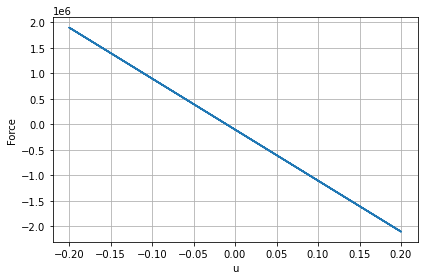

In [5]:
plt.plot(moving_mesh[-1, :] - L0, force,)
plt.xlabel("u");
plt.ylabel("Force");
plt.grid();
plt.tight_layout();

**High fidelity**

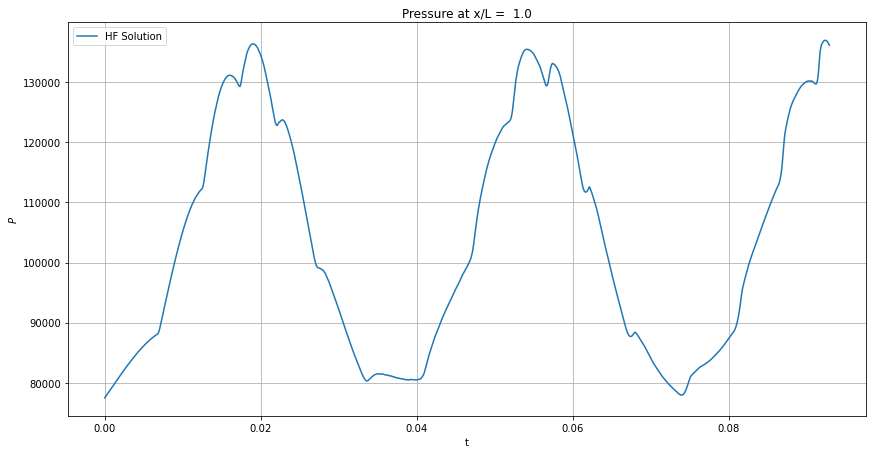

In [6]:
# Node number from Right to left (fluid domain) (Far left node having index 1) -----------
x_n = 1

fig = plt.figure(figsize = (12, 6))

plt.plot(t, fl_pressure[-x_n, :], '-', label = "HF Solution");
plt.legend();
plt.tight_layout();
plt.grid();
plt.xlabel("t");
plt.ylabel("$P$");
plt.title("Pressure at x/L =  " + str(L * (nx - x_n + 1)/nx));

In [7]:
# Choose number of equally spaced timesteps 
n_T = 2.5
n_snap = 280
frac = 1.75
ntt = int(n_snap /(frac/n_T))
dt = (t[-1] - t[0]) / (ntt - 1)

# Interpolating original data to the new timesteps
target_t = np.linspace(t[0], t[-1], ntt)
target_fl_pressure = si.griddata(t, fl_pressure.T, target_t, method='linear').T
target_fl_velocity = si.griddata(t, fl_velocity.T, target_t, method='linear').T
target_fl_m_mesh = si.griddata(t, moving_mesh.T, target_t, method='linear').T
target_sol_accel = si.griddata(t, sol_accel.T, target_t, method='linear').T

In [8]:
# Choose coefficient of time interval(of data) chosen for training
Coeff = frac/n_T


# Training data (considering moving mesh AND mass acceleration)
XY_DATA = np.concatenate((target_fl_pressure[:, :int(ntt * Coeff)], target_fl_velocity[:, :int(ntt * Coeff)], 
                          target_fl_m_mesh[:, :int(ntt * Coeff)], target_sol_accel[:int(ntt * Coeff)][np.newaxis, :]))
X = XY_DATA[:, :-1]
Y = XY_DATA[:, 1::]

In [9]:
rank = 100
dmd = DMD()
drom = ROM(dmd)
drom.decompose(X,  Y = Y, dt = dt, rank =rank, normalize=True, opt_trunc = True)

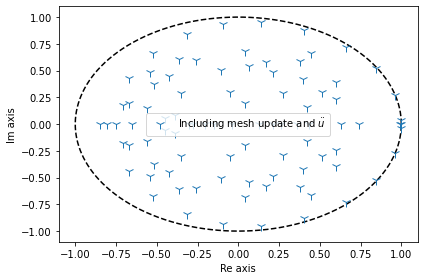

In [10]:
plt.xlabel("Re axis");
plt.ylabel("Im axis");
theta = np.linspace(0, 2*np.pi, 1024)
plt.plot(np.cos(theta), np.sin(theta), "k--");
plt.plot(np.real(drom.model.lambd), np.imag(drom.model.lambd), '1', markersize = 10, label = r"Including mesh update and $\ddot{u}$");
plt.legend();
plt.tight_layout();

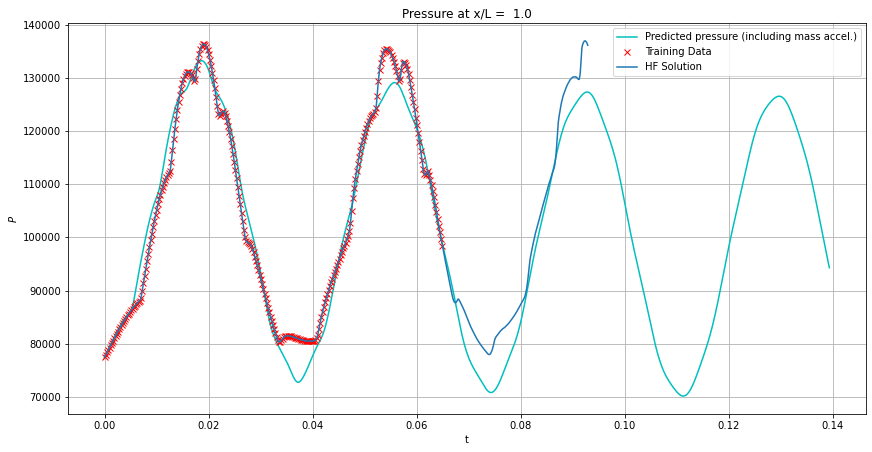

In [11]:
# Node number from Right to left (fluid domain) (Far left node having index 1) -----------
x_n = 1
satbilize_ = False

fig = plt.figure(figsize = (12, 6))
prediction_t = np.concatenate((target_t, np.linspace(target_t[-1] + dt, 1.5 * target_t[-1], int(ntt))))
predicted_X = np.real(drom.predict(prediction_t, t1 = t[0], stabilize=satbilize_))

predicted_mesh = predicted_X[2 * nx : 3 * nx, :]
predicted_pressure = predicted_X[:nx, :]

plt.plot(prediction_t, predicted_pressure[-x_n, :], '-c', label = "Predicted pressure (including mass accel.)")
plt.plot(target_t[: int(ntt * Coeff)], target_fl_pressure[-x_n, :int(ntt * Coeff)], 'xr', label = "Training Data");
plt.plot(t, fl_pressure[-x_n, :], '-', label = "HF Solution");
plt.legend();
plt.tight_layout();
plt.grid();
plt.xlabel("t");
plt.ylabel("$P$");
plt.title("Pressure at x/L =  " + str(L * (nx - x_n + 1)/nx));

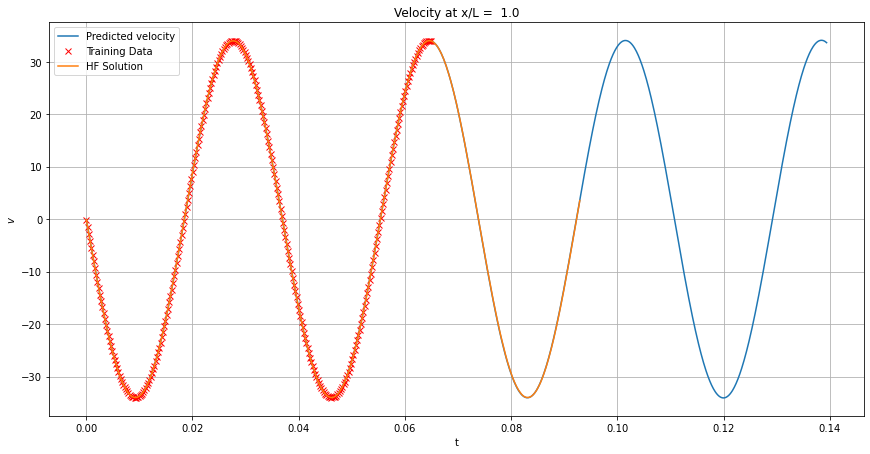

In [12]:
fig = plt.figure(figsize = (12, 6))

predicted_velocity = predicted_X[nx:2*nx, :]

plt.plot(prediction_t, predicted_velocity[-x_n, :], '-', label = "Predicted velocity")
plt.plot(target_t[: int(ntt * Coeff)], target_fl_velocity[-x_n, :int(ntt * Coeff)], 'xr', label = "Training Data");

plt.plot(t, fl_velocity[-x_n, :], '-', label = "HF Solution");
plt.legend();
plt.tight_layout();
plt.grid();

plt.xlabel("t");
plt.ylabel("$v$");
plt.title("Velocity at x/L =  " + str(L * (nx - x_n + 1)/nx));

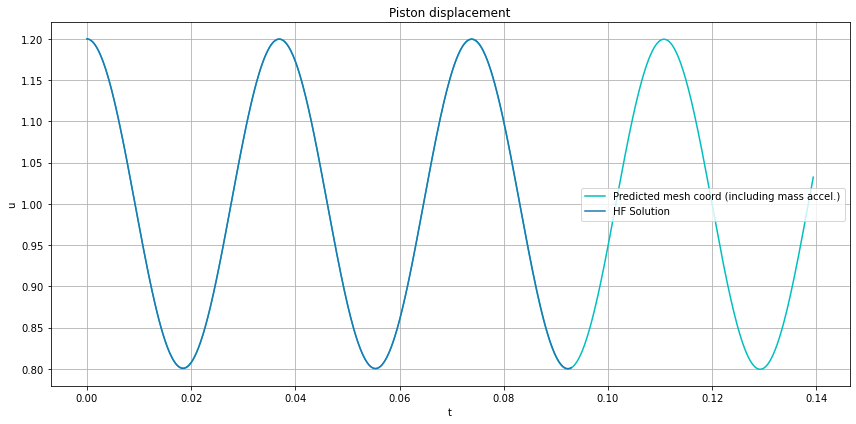

In [13]:
fig = plt.figure(figsize = (12, 6))

plt.plot(prediction_t, predicted_mesh[-1, :], '-c', label = "Predicted mesh coord (including mass accel.)");
plt.plot(t, moving_mesh[-1, :], '-', label = "HF Solution");
plt.legend();
plt.grid();
plt.title("Piston displacement");
plt.xlabel("t");
plt.ylabel("u");
plt.tight_layout();